<a href="https://colab.research.google.com/github/aagamj/Stocks/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install nsetools
!pip install mplfinance

     |████████████████████████████████| 6.3 MB 8.6 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=6b664f2b9b29d826e4fbdeffd533021d223a10ec7a32a8af4a9ea6a5a6e06c5e
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 62 kB 958 kB/s 


In [ ]:
import yfinance as yf
import mplfinance as mpf
import pandas as pd
import numpy as np
import math
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed


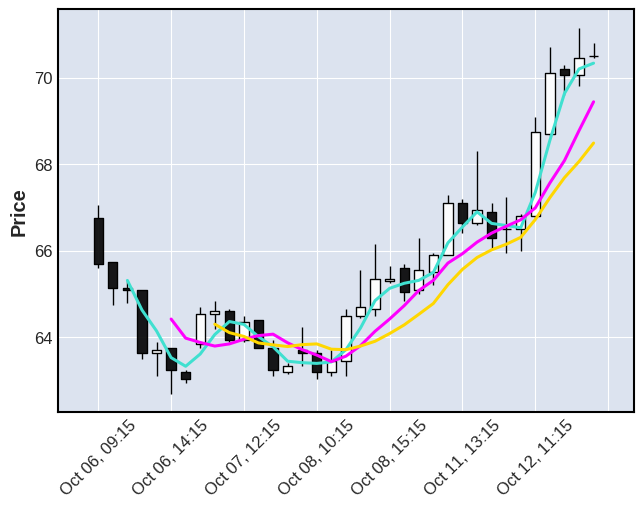

In [5]:
data = yf.download(tickers='bhel.NS', period='5d', interval='1h')
mpf.plot(data,type='candle',mav = (3,6,9))

In [14]:
def get_stock_price(symbol):
  df = yf.download(symbol, start='2021-02-01', threads= False)
  df['Date'] = pd.to_datetime(df.index)
  df['Date'] = df['Date'].apply(mpl_dates.date2num)
  df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
  return dfsymbol = 'COST'
symbol = 'Reliance.NS'
df = get_stock_price(symbol)

SyntaxError: ignored